# Lightcurves of stars
* Apparent magnitude calibration of our objects
* Time series analysis of the brightness of stars

## Overview from last time:

* Finding objects and measuring flux

In [97]:
#this gives us access to numpy as np, and matplotlib.pyplot as plt
%pylab inline

#Astronomical imports!... exotic
from astropy.io import fits
from astropy import wcs as wcs
import sep
import glob


Populating the interactive namespace from numpy and matplotlib


/Users/crisp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'flag']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Overview: Opening and plotting objects in an image
 <font color='blue'> Exercise: let's read an image as we learned in previous lectures and let's define the data and the header:
</font>

Hints: 
* our file is the same as last time `16335757.fits`
* we use the astropy.io function: `fits.open(filename)` to open the file
* this returns an HDU list, our data and header will be in the 0th item in this list (`list[0].data, list[0].header`)
* lets call them `img` and `header` respectively
* you can use `plot.hist(img.flatten(), bins=N, range(-x1, x2))` to find the vmin and vmax of your data. Experimentally determine N, x1, and x2. Maybe start with N=10 and x1 = -10, x2 = 10 and then go from there.

<font color='blue'> Plot your img data! </font>
* using `imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=x1, vmax=x2)` 

/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


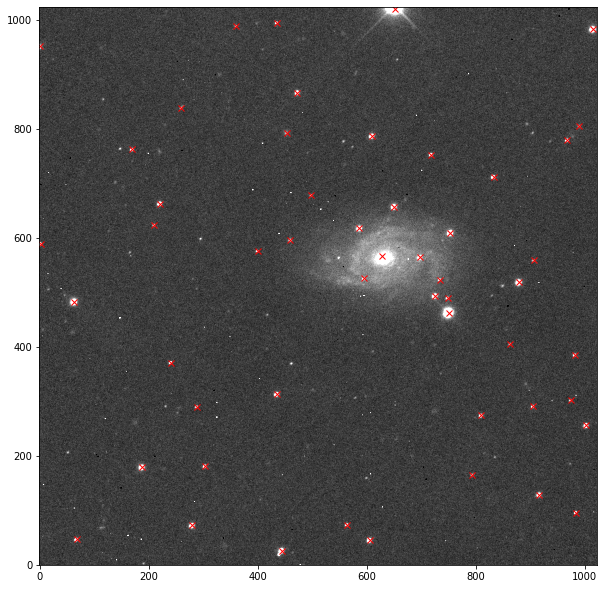

In [98]:
hdu_list = fits.open('16335757.fits')
img = hdu_list[0].data
header = hdu_list[0].header
#image_hist = plt.hist(img.flatten(), bins=100)
#image_hist = plt.hist(img.flatten(), bins=1000, range=(-10,500))
img = img.byteswap().newbyteorder() # magic command
bkg = sep.Background(img)
img_sub = img-bkg
objects = sep.extract(img, 
                      thresh=20.0, 
                      err=bkg.globalrms, 
                      mask=None, 
                      minarea=10, 
                      clean=True, 
                      clean_param=1.0, 
                      segmentation_map=False
                    )

plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

# Overview: Crossmatching and finding flux/magnitude
Say we know the RA and DEC of an interesting star, how do I find it in my objects list, then find its magnitude?
<br><br>
If we know the sky coordinates of one interesting object, how can we find its position in the image? To do that we can use the information on the header of the file and convert the coordinate in pixel position using the To do that we can use the information on the header of the file and convert the coordinate in pixel position using the [wcs](https://docs.astropy.org/en/stable/wcs/) package in astropy.
<br><br>
Let's plot the image again, and this time mark the position of the star in the image. 

* <font color='blue'>Fill in the last plotting command to mark the star of interest, using a different plotting symbol and color.</font>

my object should be close to these coordinate
611.6228472316652 786.023106657171


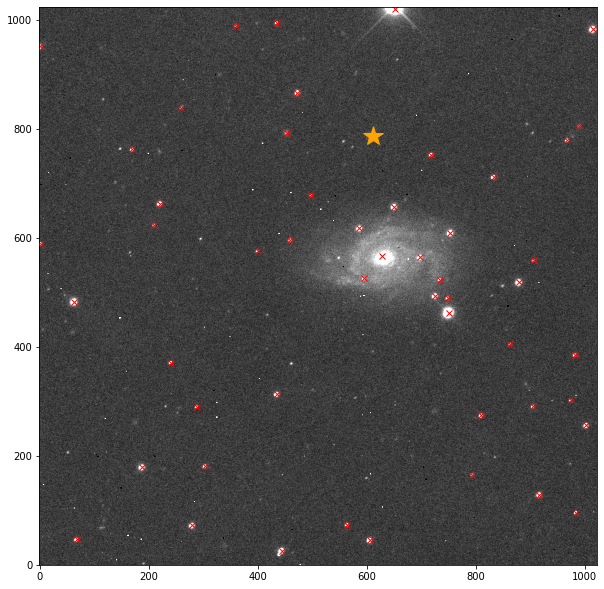

In [99]:
# import the wcs package
from astropy.wcs import WCS
# read in the WCS solution from the header
w = WCS(header)
#transform coordinate in pixels:
Ra = 148.283666667
Dec = 16.7139583333
px, py = w.wcs_world2pix(Ra,Dec, 1)
print('my object should be close to these coordinate')
print(px,py)

plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

plt.plot(px,py,'*',color='orange',markersize=20)

EXERCISE:
<font color='blue'> Loop throught the objects dictionary to find the object that is close to our object of interest.</font>

Hints:
* The x,y values are stored in `objects['x'], objects['y']`, respectively. 
* The x,y values for our object of interst are stored in `px, py`, respectively
* Recall the formula for the distance between two points: sqrt((x1 - x2)^2 + (y1 - y2)^2)
* You can use a distance threshold of 10 pixels to decide if an object is close enough. 



In [100]:
for i,j in enumerate(objects['x']):
    distance = np.sqrt((objects['x'][i]-px)**2+(objects['y'][i]-py)**2)
    #print('distance ', distance)
    if distance < 10:
        print('FOUND', i)
        print('The coordinate is', objects['x'][i], objects['y'][i])
        break
        
        

FOUND 42
The coordinate is 610.0990721706914 786.4525192719032


# Overview: Photometry and Flux
Now what we want to do with these objects? We probably want to measure how much light is emitted by each of them.

Let's zoom on the one we found of them by cutting a small box of 40 x 40 pixels with one object in the center.Tto cut a region we should do  <font color='blue'> img[a:b,c:d] </font> with a,b,c,d the pixels (integer) at the edges of the small matrix. 

* let's do that for the element 10 of the object dictionary. `object['x'][10]` and `object['y'][10]`

* let's now plot the zoomed image!



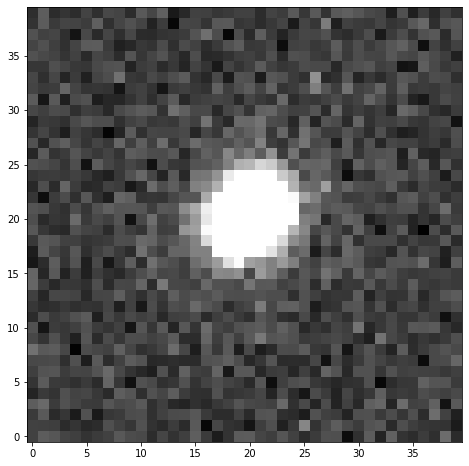

In [101]:
obj_y = int(objects['y'][42])
obj_x = int(objects['x'][42])


#The entire slice! -20 and + 20 all around this object from the image data
obj = img[
    obj_y-20:obj_y+20,
    obj_x-20:obj_x+20
  ] 

fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)

### How do we define where the star `begins` or `ends`??

Let's do a test!

We want to see the amount of flux at a given radius going out from the center of the circle. I will define the `edge` of my star where the amount of flux stops growing.

* We can utilize the `sep.sum_circle()` function to find the amount of flux inside a given radius
* Below, we iterate radii from 1-20 pixels from the center of our star, and plot the flux.
* here we use the background-subtracted image: `img_sub`



Text(0, 0.5, 'flux (counts)')

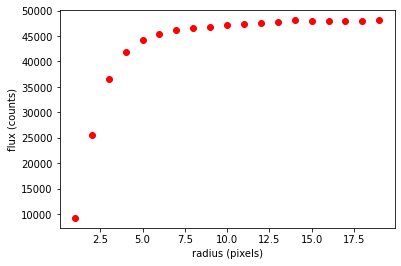

In [102]:
fluxvec = []
radiuscev = []
for radius in range(1,20):
    flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         radius, err=bkg.globalrms, gain=1.0)
    fluxvec.append(flux)
    radiuscev.append(radius)

plt.plot(radiuscev,fluxvec,'or')
plt.xlabel('radius (pixels)')
plt.ylabel('flux (counts)')



Let's select the region to get all the counts of the object. We can use a circle.

<font color='blue'> From the plot above: How large should be the radius? </font>

EXERCISE:

* <font color='blue'> Lets plot 3 circles of different radii (8,10,12) around our object to get an idea where the flux is coming from.</font>

Hint:

* To plot a circle you will first need to define a matplotlib `Circle` object and then add it to your ax patches like so:

```
c1 = Circle((x,y),radius, color='r', lw=4, fill=False)
ax.add_patch(c1)
```

* here (x,y) will be the center of our star (20, 20)
* lw - stands for linewidth, let's leave it at 4 pixels wide
* fill=False, we leave this at false. If true, it will plot an full colored circle, not just a ring.


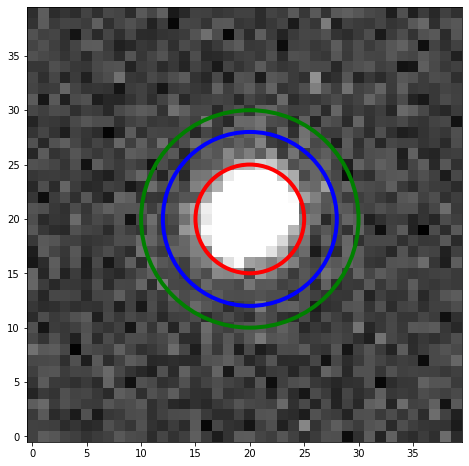

In [103]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)
ring1 = Circle((20,20),5 ,color='r', lw=4, fill=False)
ring2 = Circle((20,20),8 ,color='b', lw=4, fill=False)
ring3 = Circle((20,20),10 ,color='g',lw=4, fill=False)
ax.add_patch(ring1)
ax.add_patch(ring2)
ax.add_patch(ring3)

### Now that we have defined the "Edge" of our star, Lets get its flux!

EXERCISE: <font color='blue'>Measuring Flux of our object</font>
* using the sep.sum_circle() method from above obtain the flux and error from our 10th element object
* `flux, fluxerr, flag = sep.sum_circle(img_sub, [x], [y], radius, err=bkg.globalrms, gain=1.0)`



In [104]:
flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         10, err=bkg.globalrms, gain=1.0)

print(flux)

[47091.98190247]


### To clarify:

* What we have just measured is the number of counts within a radius of ?? pixel(s) for one object we selected in the image. 
* How do we use this measurement in astronomy? We usually convert this measurment into a magnitude, and if we know how our telescope is performing, then we know how bright a star appears to be. How bright actually is (absolute magnitude) depends on how far the star is. 

### Magnitudes!
* <font color='blue'> Let's first convert the flux into an instrumental magnitude. </font> 
* The equation we will use is `inst_mag = -2.5*np.log10(flux)`
* print it out!


In [105]:
inst_mag = -2.5 *np.log10(flux[0])
print('instrumental magnitude ', inst_mag)


instrumental magnitude  -11.682367421115941


### We are not done yet...

* We still need to transform this 'instrumental magnitude' into a calibrated apparent magnitude. This value will actually mean something astronomically, in comparison with a standardized magnitude system. 

* In order to do this primary calibration, we need to know the apparent magnitude of at least one object in the field... a <b>standard star</b>! 

* We need to measure its instrumental magnitude and subtract it from its known apparent magnitude and obtain what we call the "<b>zeropoint</b>".

* Once we have the zeropoint, we can measure the magnitudes of any object in the image by adding it to the instrumental magnitude!

EXERCISE: <font color='blue'> Measuring the zeropoint. </font>

* <font color='blue'> I know the apparent magnitude of the 9th element of our objects is 15, using the code above calculate the zeropoint for our image </font>

HINTS:

* Copy the code above and calculate inst_mag using the sep.sum_circle() function on the 9th element of our objects list, you can keep the radius at 10.
* `zeropoint = app_mag - inst_mag; (app_mag = 15)`
    
    

In [86]:
# instrumental magnitude for object[9]
flux9, fluxerr9, flag9 = sep.sum_circle(img_sub, [objects['x'][9]], [objects['y'][9]],
                                         10, err=bkg.globalrms, gain=1.0)
inst_mag9 = -2.5 *np.log10(flux9[0])
app_mag9 = 15 
zero_point = app_mag9 - inst_mag9
print('the zeropoint of the image is', zero_point)


the zeropoint of the image is 25.38090805363596


### The final goal! 

* <font color='blue'> Now that you know the zeropoint of the image, calculate the apparent magnitude of our star of interest! </font>

HINT:

* `app_mag = zeropoint + inst_mag`


In [95]:
app_mag10 = inst_mag + zero_point
print(app_mag10)


[11.6573657]


# Now what can we do with this technique?
## We can see how a star evolves, with time series analysis
https://www.dropbox.com/s/ycoikiu6jnxcadt/planet_x.tar.gz?dl=0 <br>

Contained is a list of images taken over a series of days. I have an interesting star and a standard star. Let's open up the first image in the list and se what it looks like!

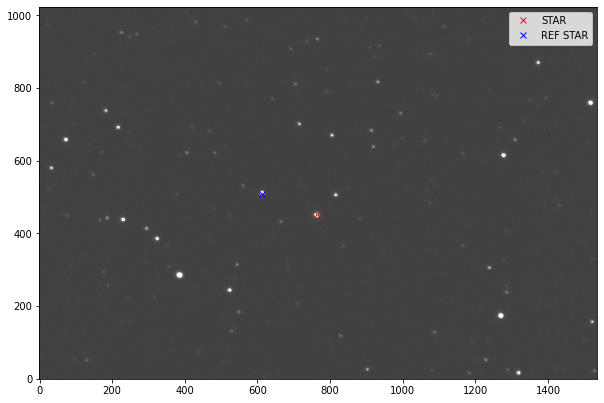

In [88]:
STAR1_RA = 268.02924375
STAR1_DEC = 37.5461769444

imglist = glob.glob('*fits')
imglist = [x for x in imglist if '16335757' not in x]
hdu= fits.open(imglist[0])
header = hdu[0].header
X = hdu[0].data

plt.figure(figsize=(10,12))
imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=50, vmax=1800)

w = WCS(header)
#transform SN coordinate in pixels:
px1, py1 = w.wcs_world2pix(STAR1_RA,STAR1_DEC, 1)

plt.plot(px1, py1,'xr', label = 'STAR')
plt.legend()

### Now lets iterate over our images, and calculate the flux's of our interesting star

In [106]:
jd_vec = []
flux_vec =[]
fluxerr_vec =[]
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    # Now we can extract all the objects from the image using the sep commmand 
    # sep.extract and then we can plot all the star detected on our image.  
    # thresh=3.0 define how many star we want to find larger numbers means 
    # we find less objects. This is similar to a dictionary with each column 
    # that can be identify by a name. 
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False) 
    w = WCS(header)
    #transform STAR coordinate in pixels:
    px, py = w.wcs_world2pix(STAR1_RA,STAR1_DEC, 1)
    
    star = False
    for i,j in enumerate(objects['x']):
        if (objects['x'][i]-px)**2+(objects['y'][i]-py)**2 <25:
            star = i
        if star is not False:
            #print("one star close to the coordinates")
            fluxstar, fluxstarerr, flagstar = sep.sum_circle(data_sub, [objects['x'][star]], [objects['y'][star]],
                                     8.0, err=bkg.globalrms, gain=1.0)
            flux_vec.append(fluxstar)
            fluxerr_vec.append(fluxstarerr)
            jd_vec.append(header['jd'])
            # once we find the closest star we can stop the enumerate with "break"
            break

/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


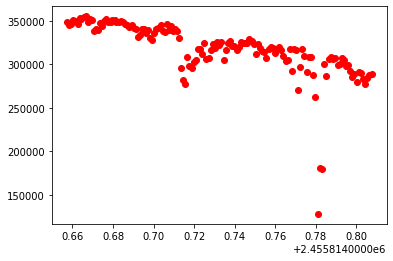

In [107]:
plt.plot(jd_vec,flux_vec,'or')

### Now this doesn't look all too interesting. 
There is a reason for that, it isn't calibrated correctly. Lets change the loop and calibrate our data to apparent magnitudes using our standard star.

EXERCISE

* <font color='blue'> Copy the code above, but this time do a test and search for the standard star as well as our interesting star. And once you've found the standard and the other star, find their instrumental magnitudes, zeropoint from the standard, and get the apparent magnitude of our interesting star </font>


HINT:
* Lets say our standard star has a known magnitude of 16
* perform two `if` statements searching for our star and the standard star
* Once you've found both, perform your calibration
* `instrumental_mag = -2.5 *np.log10(flux)`
* `zeropoint = mag_std - instrumental_mag_std`
* `app_mag = zeropoint + inst_mag`
* store the jd, and app_mag of our star in arrays, and then plot them


In [ ]:
mag_std = 16
STD_RA = 268.059616667 
STD_DEC = 37.5372694444
std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)

jd = []
mag =[]
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    # Now we can exstract all the objects from the image using the sep commmand 
    # sep.extract and then we can plot all the star detected on our image.  
    # thresh=3.0 define how many star we want to find larger numbers means 
    # we find less objects. This is similar to a dictionary with each column 
    # that can be identify by a name. 
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False) 
    w = WCS(header)
    #transform STAR and REF coordinates in pixels:
    px, py = w.wcs_world2pix(STAR1_RA, STAR1_DEC, 1)
    std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)
    
    star = False
    std  = False
    for i,j in enumerate(objects['x']):
        if (objects['x'][i] - px)**2+(objects['y'][i] - py)**2 <25:
                star=i
        if (objects['x'][i]-std_px)**2+(objects['y'][i]- std_py)**2 < 25:
                std=i
        if std is not False and star is not False:
            # measure the flux
            fluxstar, fluxstarerr, flagstar = sep.sum_circle(data_sub, [objects['x'][star]], [objects['y'][star]],
                                         8.0, err=bkg.globalrms, gain=1.0)
            fluxstd, fluxstderr, flagstd = sep.sum_circle(data_sub, [objects['x'][std]], [objects['y'][std]],
                                         8.0, err=bkg.globalrms, gain=1.0)
    
            inst_mag = -2.5 *np.log10(fluxstar)
            inst_mag_std = -2.5 *np.log10(fluxstd)
            
            zeropoint = stdmag - inst_mag_std
            inst_app_mag = zeropoint + inst_mag
            
            mag.append(inst_app_mag)
            jd.append(header['jd'])
            # once we find the closest star we can stop the enumerate with "break"
            break

/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


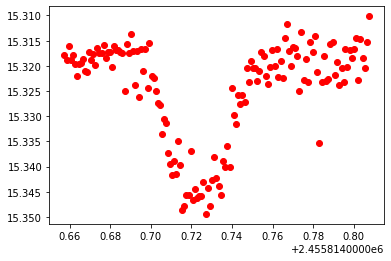

In [109]:
plt.gca().invert_yaxis() #magnitudes -> higher is dimmer, lower is brighter
plt.plot(jd,mag,'or')

# What does this look like?